In [1]:
import sys
import os
sys.path.append('scripts')

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,make_smoothing_spline
import matplotlib.pyplot as plt
import torch
from uncertainties import ufloat,umath

from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

# Perform Curve Fits to Quast EEG PSDs

In [3]:
no_power = np.array([
    [25.982256055857825, 0.3789096175722008],
    [26.313108967161075, 0.3729998477139113],
    [26.661775364168108, 0.369264435522993],
    [27.15128415830467, 0.3732192839555908],
    [27.485540459152947, 0.3787336792383785],
    [27.984752534120027, 0.37830372687210684],
    [28.286712840562256, 0.3689003681421064],
    [28.356228882333127, 0.3775427874523387],
    [28.699235667386777, 0.35999984489734943],
    [28.6169140389739, 0.3695770446168284],
    [29.092664449843312, 0.35654707121710344],
    [29.336405071302433, 0.3563564795234446],
    [29.7056579284736, 0.35115713996543585],
    [30.220127752314653, 0.34894589809337706],
    [30.783497340832763, 0.35205794827055026],
    [31.332779398158674, 0.35233009800773785],
    [31.38017669936609, 0.345042668956083],
    [31.931339601978006, 0.34462555132722406],
    [32.24217561732491, 0.3353017087778316],
    [32.34471177893695, 0.34389935937832944],
    [32.76470453130264, 0.334822348968674],
    [33.07835429119741, 0.3317422515484134],
    [33.390348907240494, 0.33407752429686804],
    [33.56993201514858, 0.3300905280481667],
    [34.15212886497963, 0.33370633035162406],
    [34.039165297101974, 0.3281531235406928],
    [34.70391244653594, 0.3358724791970132],
    [35.31515053750154, 0.3343292013191838],
    [35.46424415340486, 0.3322183282177297],
    [35.88542958295779, 0.3383839390938701],
    [36.46179935281688, 0.3383051084574884],
    [36.89040919786042, 0.33273441195494635],
    [37.03704459847086, 0.3381874895156573],
    [37.407217520900744, 0.33129900549960656],
    [37.8390348156657, 0.3371806367797768],
    [38.09542633443239, 0.33318574401429035],
    [38.37398704467138, 0.3377120779534525],
    [38.98523166909956, 0.3350441232952216],
    [39.53195489173284, 0.3351705204154319],
    [39.643896164878576, 0.3311377041896566],
    [40.04315606268102, 0.34158319479485044],
    [40.61132774618989, 0.343392495250876],
    [41.16021482600574, 0.34223345859491555],
    [41.254930432918556, 0.3376440900043977],
    [41.865208104886, 0.3367959491005597],
    [41.75544593366884, 0.3317037453472187],
    [42.44694761233699, 0.33916050252940605],
    [42.32895327827854, 0.3320124950695253],
    [43.006734685544544, 0.3385401931914867],
    [43.20914904246562, 0.3299275263565372],
    [43.70055825629614, 0.3280732218268432],
    [43.88263681185754, 0.3226838427455473],
    [44.31595347222931, 0.3270553467502693],
    [44.47699896899851, 0.3210430585070036],
    [45.026358635940426, 0.32384904407850285],
    [45.53910477862634, 0.32992475885202355],
    [45.40503812663965, 0.32453389068476546],
    [46.19578310178333, 0.3203314639089256],
    [46.82837908189827, 0.30839314131307033],
    [47.38624531710953, 0.30517933738542435],
    [47.82941008339884, 0.301549189135274],
    [48.18567979747456, 0.2944479455222222],
    [54.111922358441454, 0.26686630366283254],
    [54.763635250043386, 0.26563130477360614],
    [55.643447653706, 0.2525094415755756],
    [55.79768637138512, 0.2525952053873274],
    [56.327746189888025, 0.2427838253229177],
    [56.405951736880255, 0.2508113181028893],
    [57.21407572246665, 0.2427838253229177],
    [57.76151455141227, 0.2427838253229177],
    [58.73473913620449, 0.2372263303213989],
]).T

md_power = np.array([
    [25.749377315925404, 0.5197323262319385],
    [26.31419515531374, 0.5105212928497916],
    [26.7052228902749, 0.5050152561353239],
    [27.248316966609845, 0.48870297914012517],
    [27.600241928074887, 0.49163610150203785],
    [27.817479558608866, 0.48299110927745303],
    [29.1904213835836, 0.47866861316516063],
    [30.12019844226902, 0.44938884783308464],
    [30.02461388483407, 0.4657011248282834],
    [30.350470330635037, 0.43953458586279903],
    [31.56787001214745, 0.4342909864122919],
    [31.74513591866317, 0.44433564404466663],
    [32.70098149301267, 0.44491197685963896],
    [32.68360248256995, 0.43482615259762336],
    [33.335315374171884, 0.42926865759610455],
    [34.44322728989516, 0.41452585835596434],
    [36.18721098782194, 0.4164246691481499],
    [36.680774884395134, 0.4095086753684821],
    [37.01097608280678, 0.3999760276922658],
    [37.48020936476017, 0.4014811825885105],
    [38.105853740698024, 0.40425993008926986],
    [39.0443203046048, 0.4191142222846875],
    [39.46141655523004, 0.42905253279048994],
    [39.98278686851158, 0.4451178100078434],
    [40.08706093116789, 0.46153300357714433],
    [40.58236272878536, 0.48175611038822663],
    [40.92125343241837, 0.49348859983587745],
    [41.919305174985894, 0.4943560395318818],
    [42.60267269275135, 0.5137117066469599],
    [42.95459765421639, 0.5214819079916759],
    [43.580242030154245, 0.525598570955764],
    [44.02340679644356, 0.5167992038700259],
    [44.43398591815278, 0.490658394048067],
    [44.414434531404716, 0.5069192127562147],
    [44.67511968804549, 0.4694061214959626],
    [44.83153078202995, 0.4492344729719314],
    [45.31379832181538, 0.4367558383620396],
    [45.45717515796781, 0.42057220708446863],
    [45.81344487204353, 0.4093543005073288],
    [46.134956565233814, 0.39615524987872164],
    [46.16623878403071, 0.38943994341855304],
    [46.838806488163904, 0.3517724772971477],
    [47.15162867613283, 0.3437449845171761],
    [47.88154711472699, 0.3354087420148979],
    [48.87215070996193, 0.30978251506345006],
    [49.88882282086094, 0.30329877089501145],
    [50.723015322111415, 0.29650627700426624],
    [51.45293376070558, 0.29311003005889363],
    [52.02644110531528, 0.2756656707485707],
    [51.97430407398712, 0.28230378977816256],
    [52.65208548125313, 0.26177193324477366],
    [52.96490766922206, 0.2591475606051675],
    [53.43414095117545, 0.24826413289385985],
    [53.90337423312884, 0.2452538231013705],
    [55.238082235129596, 0.23240983465341591],
    [55.45705776670784, 0.2296928370971178],
    [56.484157283872484, 0.23166883531988008],
    [57.070698886314226, 0.23151446045872676],
    [57.29228126945888, 0.22240634365068201],
    [57.996131192388965, 0.2134526017037906]
]).T

sortidx = np.argsort(no_power[0])
no_power = no_power[:,sortidx]
sortidx = np.argsort(md_power[0])
md_power = md_power[:,sortidx]
del sortidx

In [4]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)

def rational3_4(x, p2, p1, p0, q3, q2, q1):
    return rational(x, [p2, p1, p0], [q3, q2, q1])

def lfp_bgnd_func(f, B, beta):
    return B/f**beta

def lfp_nois_func(x, p2, p1, p0, q2, q1):
    return rational(x, [p2, p1, p0], [q2, q1])

def lfp_sign_func(f, A, p0, q0, q2):
    return A * (p0 + f**2) / (q0 + q2*f**2 + f**4)

def lfp_add_func(f, A, p0, q0, q2, B, beta):
    return lfp_sign_func(f,A,p0,q0,q2) + lfp_bgnd_func(f,B,beta)

def lfp_mult_func(f, A, p0, q0, q2, a2, a1, a0, b2, b1):
    return lfp_sign_func(f,A,p0,q0,q2) * lfp_nois_func(f,a2,a1,a0,b2,b1)

In [5]:
tail_idxs = list(range(15))# + [-4,-3,-2,-1]

no_bgnd_popt,no_bgnd_perr = curve_fit(lfp_bgnd_func,no_power[0,tail_idxs],no_power[1,tail_idxs],
                                      p0=[0.1,0.5],maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lfp_bgnd_func,md_power[0,tail_idxs],md_power[1,tail_idxs],
                                      p0=[0.1,0.5],maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

print(no_bgnd_popt,no_bgnd_perr)
print(md_bgnd_popt,md_bgnd_perr)

no_bgnd_popt,no_bgnd_perr = curve_fit(lambda x,b,m: np.log(b)-m*x,np.log(no_power[0,tail_idxs]),np.log(no_power[1,tail_idxs]),
                                      p0=[0.1,0.5],maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lambda x,b,m: np.log(b)-m*x,np.log(md_power[0,tail_idxs]),np.log(md_power[1,tail_idxs]),
                                      p0=[0.1,0.5],maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

print(no_bgnd_popt,no_bgnd_perr)
print(md_bgnd_popt,md_bgnd_perr)

[1.84543732 0.48402037] [0.58935268 0.09561017]
[5.68190102 0.73867854] [1.03220957 0.05385467]
[1.89564403 0.4920959 ] [0.60248507 0.0950874 ]
[5.54244713 0.73136077] [1.04488516 0.05571949]


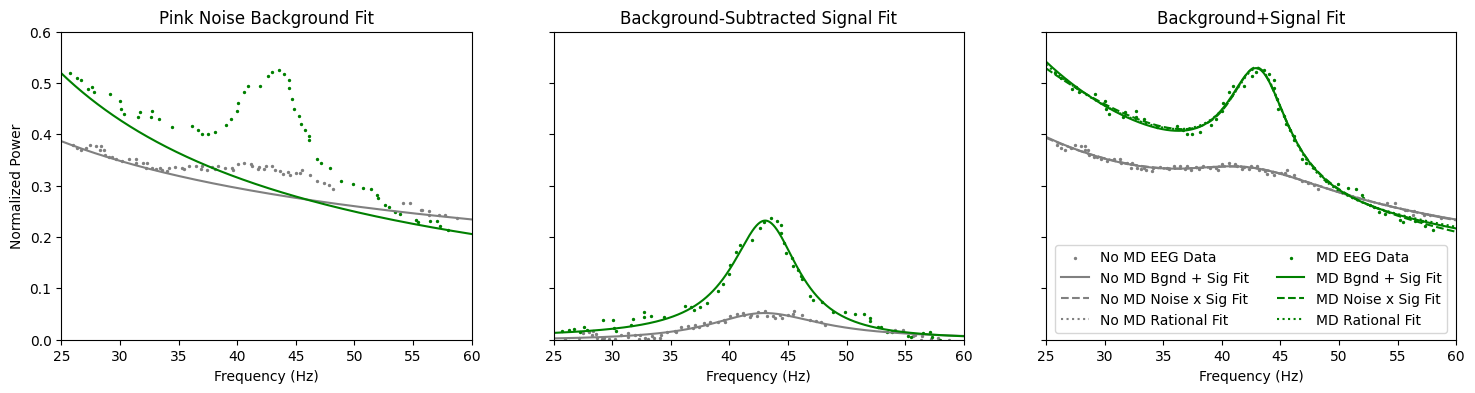

In [38]:
err_fact = 0.05
no_err = err_fact*no_power[1]
md_err = err_fact*md_power[1]
tail_idxs = list(range(10)) + [-4,-3,-2,-1]
# tail_idxs = [0,1,2,3] + [-4,-3,-2,-1]
abs_sig = False

no_rat_popt,no_rat_perr = curve_fit(rational3_4,no_power[0],no_power[1],
                                    # sigma=no_err,absolute_sigma=True,
                                    maxfev=1000000)
no_rat_cnum = np.linalg.cond(no_rat_perr/no_rat_popt[:,None]/no_rat_popt[None,:])
no_rat_perr = np.sqrt(np.diag(no_rat_perr))
md_rat_popt,md_rat_perr = curve_fit(rational3_4,md_power[0],md_power[1],
                                    # sigma=md_err,absolute_sigma=True,
                                    maxfev=1000000)
md_rat_cnum = np.linalg.cond(md_rat_perr/md_rat_popt[:,None]/md_rat_popt[None,:])
md_rat_perr = np.sqrt(np.diag(md_rat_perr))

no_bgnd_popt,no_bgnd_perr = curve_fit(lfp_bgnd_func,no_power[0,tail_idxs],no_power[1,tail_idxs],
                                    #   sigma=no_err[tail_idxs],absolute_sigma=True,
                                      p0=[5,0.5],maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lfp_bgnd_func,md_power[0,tail_idxs],md_power[1,tail_idxs],
                                    #   sigma=md_err[tail_idxs],absolute_sigma=True,
                                      p0=[5,0.5],maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

no_bgnd_popt[0] *= no_power[1,-1]/lfp_bgnd_func(no_power[0,-1],*no_bgnd_popt)
md_bgnd_popt[0] *= md_power[1,-1]/lfp_bgnd_func(md_power[0,-1],*md_bgnd_popt)

no_sign_popt,no_sign_perr = curve_fit(lfp_sign_func,no_power[0],no_power[1]-lfp_bgnd_func(no_power[0],*no_bgnd_popt),
                                    #   sigma=no_err,absolute_sigma=True,
                                      p0=[1000,100,40**4,-1000],maxfev=1000000)
no_sign_cnum = np.linalg.cond(no_sign_perr/no_sign_popt[:,None]/no_sign_popt[None,:])
no_sign_perr = np.sqrt(np.diag(no_sign_perr))
md_sign_popt,md_sign_perr = curve_fit(lfp_sign_func,md_power[0],md_power[1]-lfp_bgnd_func(md_power[0],*md_bgnd_popt),
                                    #   sigma=md_err,absolute_sigma=True,
                                      p0=[1000,100,40**4,-1000],maxfev=1000000)
md_sign_cnum = np.linalg.cond(md_sign_perr/md_sign_popt[:,None]/md_sign_popt[None,:])
md_sign_perr = np.sqrt(np.diag(md_sign_perr))

no_nois_popt,no_nois_perr = curve_fit(lfp_nois_func,no_power[0],no_power[1]/lfp_sign_func(no_power[0],*no_sign_popt),
                                    #   sigma=no_power[1]/lfp_sign_func(no_power[0],*no_sign_popt)*err_fact,absolute_sigma=True,
                                      maxfev=1000000)
no_nois_cnum = np.linalg.cond(no_nois_perr/no_nois_popt[:,None]/no_nois_popt[None,:])
no_nois_perr = np.sqrt(np.diag(no_nois_perr))
md_nois_popt,md_nois_perr = curve_fit(lfp_nois_func,md_power[0],md_power[1]/lfp_sign_func(md_power[0],*md_sign_popt),
                                    #   sigma=md_power[1]/lfp_sign_func(md_power[0],*md_sign_popt)*err_fact,absolute_sigma=True,
                                      maxfev=1000000)
md_nois_cnum = np.linalg.cond(md_nois_perr/md_nois_popt[:,None]/md_nois_popt[None,:])
md_nois_perr = np.sqrt(np.diag(md_nois_perr))

no_add_p0 = np.concatenate([no_sign_popt,no_bgnd_popt])
md_add_p0 = np.concatenate([md_sign_popt,md_bgnd_popt])

no_add_popt,no_add_perr = curve_fit(lfp_add_func,no_power[0],no_power[1],
                                    #   sigma=no_err,absolute_sigma=True,
                                    p0=no_add_p0,bounds=([0,-np.inf,-np.inf,-np.inf,0,0],
                                                         [np.inf,np.inf,np.inf,np.inf,np.inf,2]),maxfev=1000000)
no_add_cnum = np.linalg.cond(no_add_perr/no_add_popt[:,None]/no_add_popt[None,:])
no_add_perr = np.sqrt(np.diag(no_add_perr))
md_add_popt,md_add_perr = curve_fit(lfp_add_func,md_power[0],md_power[1],
                                    #   sigma=md_err,absolute_sigma=True,
                                    p0=md_add_p0,bounds=([0,-np.inf,-np.inf,-np.inf,0,0],
                                                         [np.inf,np.inf,np.inf,np.inf,np.inf,2]),maxfev=1000000)
md_add_cnum = np.linalg.cond(md_add_perr/md_add_popt[:,None]/md_add_popt[None,:])
md_add_perr = np.sqrt(np.diag(md_add_perr))

no_mult_p0 = np.concatenate([no_sign_popt,no_nois_popt])
md_mult_p0 = np.concatenate([md_sign_popt,md_nois_popt])

no_mult_popt,no_mult_perr = curve_fit(lfp_mult_func,no_power[0],no_power[1],
                                    #   sigma=no_err,absolute_sigma=True,
                                      p0=no_mult_p0,bounds=([0,-np.inf,-np.inf,-np.inf]+([-np.inf]*5),
                                                            [np.inf,np.inf,np.inf,np.inf]+([np.inf]*5)),
                                      maxfev=1000000)
no_mult_cnum = np.linalg.cond(no_mult_perr/no_mult_popt[:,None]/no_mult_popt[None,:])
no_mult_perr = np.sqrt(np.diag(no_mult_perr))
md_mult_popt,md_mult_perr = curve_fit(lfp_mult_func,md_power[0],md_power[1],
                                    #   sigma=md_err,absolute_sigma=True,
                                      p0=md_mult_p0,bounds=([0,-np.inf,-np.inf,-np.inf]+([-np.inf]*5),
                                                            [np.inf,np.inf,np.inf,np.inf]+([np.inf]*5)),
                                      maxfev=1000000)
md_mult_cnum = np.linalg.cond(md_mult_perr/md_mult_popt[:,None]/md_mult_popt[None,:])
md_mult_perr = np.sqrt(np.diag(md_mult_perr))

fs = np.linspace(25,60,1000)

fig,axs = plt.subplots(1,3,figsize=(6*3,4*1),sharex=True,sharey=True)

axs[0].scatter(no_power[0],no_power[1],c='gray',s=2,label='No MD EEG Data')
axs[0].plot(fs,lfp_bgnd_func(fs,*no_bgnd_popt),c='gray',label='No MD Pink Noise Fit')
axs[0].scatter(md_power[0],md_power[1],c='g',s=2,label='MD EEG Data')
axs[0].plot(fs,lfp_bgnd_func(fs,*md_bgnd_popt),c='g',label='MD Pink Noise Fit')
axs[0].set_title('Pink Noise Background Fit')

axs[1].scatter(no_power[0],no_power[1]-lfp_bgnd_func(no_power[0],*no_bgnd_popt),
               c='gray',s=2,label='No MD EEG Periodic Data')
axs[1].plot(fs,lfp_sign_func(fs,*no_sign_popt),c='gray',label='No MD Periodic Fit')
axs[1].scatter(md_power[0],md_power[1]-lfp_bgnd_func(md_power[0],*md_bgnd_popt),
               c='g',s=2,label='MD EEG Periodic Data')
axs[1].plot(fs,lfp_sign_func(fs,*md_sign_popt),c='g',label='MD Periodic Fit')
axs[1].set_title('Background-Subtracted Signal Fit')

axs[2].scatter(no_power[0],no_power[1],c='gray',s=2,label='No MD EEG Data')
axs[2].plot(fs,lfp_add_func(fs,*no_add_popt),c='gray',label='No MD Bgnd + Sig Fit')
axs[2].plot(fs,lfp_mult_func(fs,*no_mult_popt),c='gray',ls='--',label='No MD Noise x Sig Fit')
axs[2].plot(fs,rational3_4(fs,*no_rat_popt),c='gray',ls=':',label='No MD Rational Fit')
axs[2].scatter(md_power[0],md_power[1],c='g',s=2,label='MD EEG Data')
axs[2].plot(fs,lfp_add_func(fs,*md_add_popt),c='g',label='MD Bgnd + Sig Fit')
axs[2].plot(fs,lfp_mult_func(fs,*md_mult_popt),c='g',ls='--',label='MD Noise x Sig Fit')
axs[2].plot(fs,rational3_4(fs,*md_rat_popt),c='g',ls=':',label='MD Rational Fit')
axs[2].set_title('Background+Signal Fit')

for i in range(3):
    axs[i].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Normalized Power')

axs[0].set_xlim(25,60)
axs[1].set_ylim(0,0.6)

axs[2].legend(ncol=2,loc='lower center')

In [39]:
print('Separate Background Plus Signal Fit Results:')
print('------------------------------------------')
print('No MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    no_bgnd_popt[0],no_bgnd_perr[0],no_bgnd_popt[1],no_bgnd_perr[1]))
print('   MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    md_bgnd_popt[0],md_bgnd_perr[0],md_bgnd_popt[1],md_bgnd_perr[1]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_sign_popt[0],no_sign_perr[0],no_sign_popt[1],no_sign_perr[1],
    no_sign_popt[2],no_sign_perr[2],no_sign_popt[3],no_sign_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_sign_popt[0],md_sign_perr[0],md_sign_popt[1],md_sign_perr[1],
    md_sign_popt[2],md_sign_perr[2],md_sign_popt[3],md_sign_perr[3]))
print()
print('Combined Background Plus Signal Fit Results:')
print('------------------------------------------')
print('No MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    no_add_popt[4],no_add_perr[4],no_add_popt[5],no_add_perr[5]))
print('   MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    md_add_popt[4],md_add_perr[4],md_add_popt[5],md_add_perr[5]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_add_popt[0],no_add_perr[0],no_add_popt[1],no_add_perr[1],
    no_add_popt[2],no_add_perr[2],no_add_popt[3],no_add_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_add_popt[0],md_add_perr[0],md_add_popt[1],md_add_perr[1],
    md_add_popt[2],md_add_perr[2],md_add_popt[3],md_add_perr[3]))
print()
print('No MD Condition Number = {:.4f}'.format(no_add_cnum))
print('   MD Condition Number = {:.4f}'.format(md_add_cnum))
print()
print('No MD RMSE = {:.4f}'.format(np.sqrt(np.mean((no_power[1]-lfp_add_func(no_power[0],*no_add_popt))**2))))
print('   MD RMSE = {:.4f}'.format(np.sqrt(np.mean((md_power[1]-lfp_add_func(md_power[0],*md_add_popt))**2))))
print()
print('No MD R^2 = {:.4f}'.format(1-np.mean((no_power[1]-lfp_add_func(no_power[0],*no_add_popt))**2)/\
    np.var(no_power[1])))
print('   MD R^2 = {:.4f}'.format(1-np.mean((md_power[1]-lfp_add_func(md_power[0],*md_add_popt))**2)/\
    np.var(md_power[1])))

Separate Background Plus Signal Fit Results:
------------------------------------------
No MD Background Parameters: B = 2.441 +- 0.174, β = 0.572 +- 0.020
   MD Background Parameters: B = 15.548 +- 1.481, β = 1.056 +- 0.027

No MD Signal Parameters: A = 7.439651 +- 1.950339, p0 = -72 +- 351, q0 = 3404326 +- 110333, q2 = -3553 +- 65
   MD Signal Parameters: A = 0.000300 +- 2.197038, p0 = 71073864 +- 519656732390.12, q0 = 3525460 +- 38373, q2 = -3706 +- 20

Combined Background Plus Signal Fit Results:
------------------------------------------
No MD Background Parameters: B = 4.009 +- 0.824, β = 0.716 +- 0.058
   MD Background Parameters: B = 15.753 +- 1.167, β = 1.053 +- 0.022

No MD Signal Parameters: A = 32.287761 +- 12.955120, p0 = -840 +- 177, q0 = 3123589 +- 208162, q2 = -3257 +- 150
   MD Signal Parameters: A = 0.000200 +- 0.000016, p0 = 89901191 +- 0.00, q0 = 3521382 +- 20744, q2 = -3711 +- 10

No MD Condition Number = 511597.4175
   MD Condition Number = 5649538968819484672.000

In [40]:
print('Separate Noise Times Signal Fit Results:')
print('---------------------------------------')
print(('No MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        no_nois_popt[0],no_nois_perr[0],no_nois_popt[1],no_nois_perr[1],no_nois_popt[2],no_nois_perr[2],
        no_nois_popt[3],no_nois_perr[3],no_nois_popt[4],no_nois_perr[4]))
print(('   MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        md_nois_popt[0],md_nois_perr[0],md_nois_popt[1],md_nois_perr[1],md_nois_popt[2],md_nois_perr[2],
        md_nois_popt[3],md_nois_perr[3],md_nois_popt[4],md_nois_perr[4]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_sign_popt[0],no_sign_perr[0],no_sign_popt[1],no_sign_perr[1],
    no_sign_popt[2],no_sign_perr[2],no_sign_popt[3],no_sign_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_sign_popt[0],md_sign_perr[0],md_sign_popt[1],md_sign_perr[1],
    md_sign_popt[2],md_sign_perr[2],md_sign_popt[3],md_sign_perr[3]))
print()
print('Combined Noise Times Signal Fit Results:')
print('---------------------------------------')
print(('No MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        no_mult_popt[4],no_mult_perr[4],no_mult_popt[5],no_mult_perr[5],no_mult_popt[6],no_mult_perr[6],
        no_mult_popt[7],no_mult_perr[7],no_mult_popt[8],no_mult_perr[8]))
print(('   MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        md_mult_popt[4],md_mult_perr[4],md_mult_popt[5],md_mult_perr[5],md_mult_popt[6],md_mult_perr[6],
        md_mult_popt[7],md_mult_perr[7],md_mult_popt[8],md_mult_perr[8]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_mult_popt[0],no_mult_perr[0],no_mult_popt[1],no_mult_perr[1],
    no_mult_popt[2],no_mult_perr[2],no_mult_popt[3],no_mult_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_mult_popt[0],md_mult_perr[0],md_mult_popt[1],md_mult_perr[1],
    md_mult_popt[2],md_mult_perr[2],md_mult_popt[3],md_mult_perr[3]))
print()
print('No MD Condition Number = {:.4f}'.format(no_mult_cnum))
print('   MD Condition Number = {:.4f}'.format(md_mult_cnum))
print()
print('No MD RMSE = {:.4f}'.format(np.sqrt(np.mean((no_power[1]-lfp_mult_func(no_power[0],*no_mult_popt))**2))))
print('   MD RMSE = {:.4f}'.format(np.sqrt(np.mean((md_power[1]-lfp_mult_func(md_power[0],*md_mult_popt))**2))))
print()
print('No MD R^2 = {:.4f}'.format(1-np.mean((no_power[1]-lfp_mult_func(no_power[0],*no_mult_popt))**2)/\
    np.var(no_power[1])))
print('   MD R^2 = {:.4f}'.format(1-np.mean((md_power[1]-lfp_mult_func(md_power[0],*md_mult_popt))**2)/\
    np.var(md_power[1])))

Separate Noise Times Signal Fit Results:
---------------------------------------
No MD Noise Parameters: a2 = 48.891 +- 1295.055, a1 = -4113.815 +- 108980.428, a0 = 88437.156 +- 2343053.653, b2 = 0.143 +- 3.761, b1 = 0.787 +- 22.536
   MD Noise Parameters: a2 = 0.120 +- 0.011, a1 = -10.362 +- 0.969, a0 = 225.435 +- 21.244, b2 = 0.000 +- 0.000, b1 = 0.000 +- 0.005

No MD Signal Parameters: A = 7.439651 +- 1.950339, p0 = -72 +- 351, q0 = 3404326 +- 110333, q2 = -3553 +- 65
   MD Signal Parameters: A = 0.000300 +- 2.197038, p0 = 71073864 +- 519656732390.12, q0 = 3525460 +- 38373, q2 = -3706 +- 20

Combined Noise Times Signal Fit Results:
---------------------------------------
No MD Noise Parameters: a2 = 50.959 +- 616334.920, a1 = -4154.934 +- 50253271.630, a0 = 88481.702 +- 1070172587.222, b2 = 0.101 +- 212.589, b1 = 5.577 +- 11686.983
   MD Noise Parameters: a2 = 0.158 +- 1111.864, a1 = -13.654 +- 95810.468, a0 = 296.696 +- 2081890.372, b2 = 0.000 +- 0.000, b1 = 0.002 +- 0.010

No MD S

In [53]:
no_p0 = ufloat(no_add_popt[1],no_add_perr[1])
md_p0 = ufloat(md_add_popt[1],md_add_perr[1])

no_q0 = ufloat(no_add_popt[2],no_add_perr[2])
md_q0 = ufloat(md_add_popt[2],md_add_perr[2])

no_q2 = ufloat(no_add_popt[3],no_add_perr[3])
md_q2 = ufloat(md_add_popt[3],md_add_perr[3])

no_fr = umath.sqrt(umath.sqrt(no_p0**2-no_p0*no_q2+no_q0) - no_p0)
md_fr = umath.sqrt(umath.sqrt(md_p0**2-md_p0*md_q2+md_q0) - md_p0)

no_Ar = 1/(no_q2+2*no_fr**2)
no_A50 = lfp_sign_func(50,1,no_p0,no_q0,no_q2)
md_Ar = 1/(md_q2+2*md_fr**2)
md_A50 = lfp_sign_func(50,1,md_p0,md_q0,md_q2)

no_wr = umath.sqrt(-(no_p0+no_fr**2)*(no_q2**2-4*no_q0)**2/8/(no_q2+2*no_fr**2)/(4*no_p0*(2*no_p0*no_q2-2*no_q0+3*no_q2*no_fr**2)-(4*no_q0+no_q2**2-4*no_q2*no_fr**2)*no_fr**2))
md_wr = umath.sqrt(-(md_p0+md_fr**2)*(md_q2**2-4*md_q0)**2/8/(md_q2+2*md_fr**2)/(4*md_p0*(2*md_p0*md_q2-2*md_q0+3*md_q2*md_fr**2)-(4*md_q0+md_q2**2-4*md_q2*md_fr**2)*md_fr**2))

print(r'$f_r$ =',no_fr,md_fr)
print(r'$A_r/A_\eta$ =',no_Ar,md_Ar)
print(r'$A_r/A_50$ =',no_Ar/no_A50,md_Ar/md_A50)
print(r'$w_r$ =',no_wr,md_wr)

$f_r$ = 43.4+/-1.4 43.08+/-0.06
$A_r/A_\eta$ = 0.0019+/-0.0013 (1.1+/-0.4)e+03
$A_r/A_50$ = 1.4+/-0.5 6.3+/-1.9
$w_r$ = 6.0+/-2.1 2.3+/-0.4


In [ ]:
lfp_sign_func(no_fr,*no_add_popt[:4])/lfp_sign_func(no_fr,*no_add_popt[:4])

0.001945474236617384+/-1.4876309091582727e-19

# Use SBI to Infer Weights and Inputs from Rates and LFP PSD Peak Features

In [ ]:
def calc_lfp_params(W,r,k,n,t,c):
    v = (r/k)**1/n
    h = v - W@r
    J = W*(n*k*v**(n-1))[None,:]
    
    p0 = (J[0,1]**2 - 2*c*J[0,1]*(1+J[1,1]) + (1+J[1,1])**2)/t[1]**2
    q0 = (1+J[0,0]) - J[0,1]*J[1,0] + J[1,1] + J[0,0]*J[1,1]

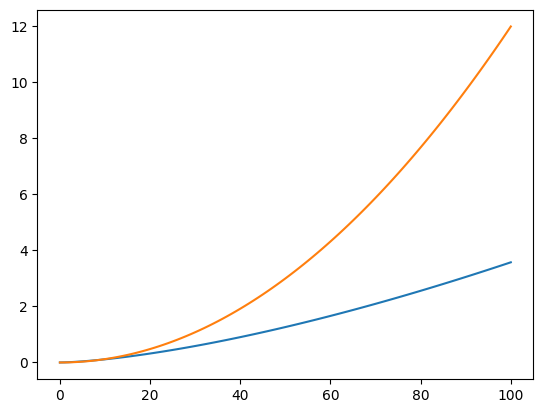

In [35]:
hs = np.linspace(0,20,101)
plt.plot(0.04*hs**1.5)
plt.plot(0.03*hs**2)